running typecheck
Success: no issues found in 1 source file

running flake8
flake8 success


<Figure size 432x288 with 0 Axes>

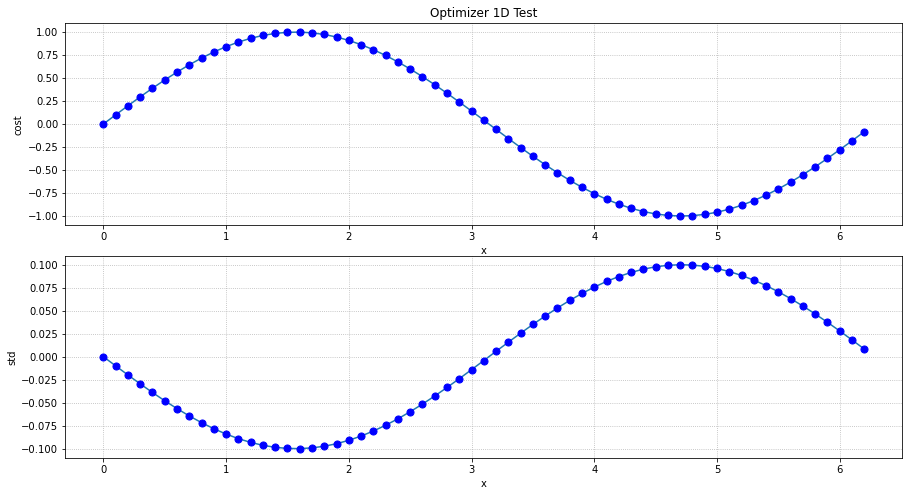

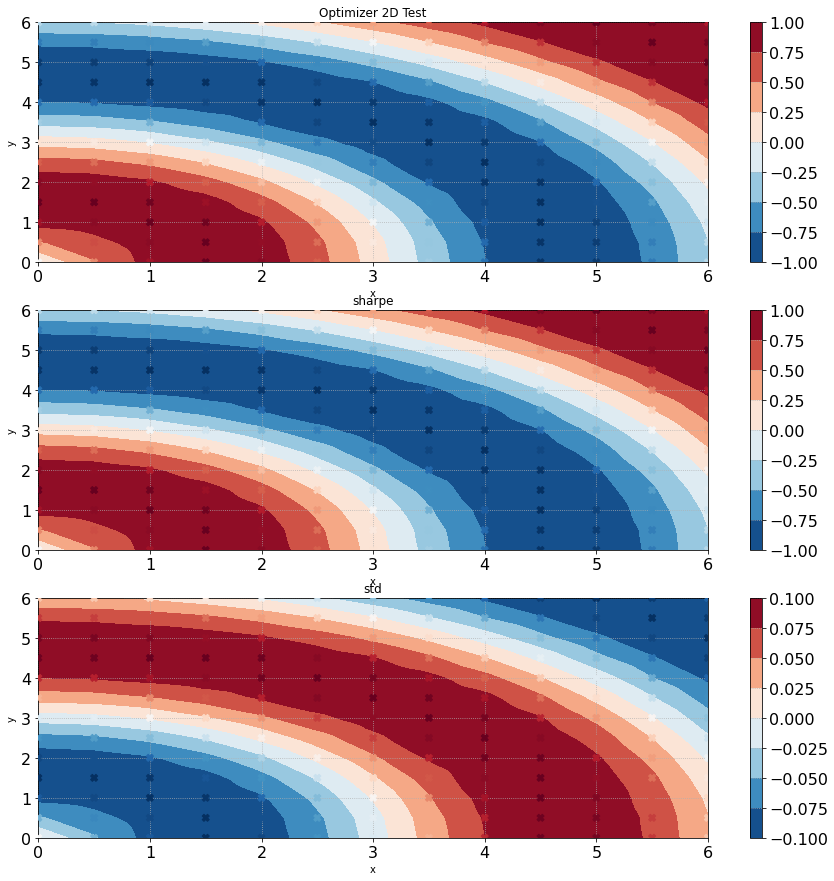

In [1]:
%%checkall
import numpy as np
import pandas as pd
import os
import sys
import concurrent
import concurrent.futures
import multiprocessing as mp
from pyqstrat.pq_utils import has_display
from pyqstrat.plot import Plot, Subplot, XYData, XYZData, SurfacePlotAttributes, LinePlotAttributes, ContourPlotAttributes
from typing import Mapping, Any, Callable, Generator, Tuple, Sequence, List, Optional, Union


class Experiment:
    '''An Experiment stores a suggestion and its result'''
    def __init__(self, suggestion: Mapping[str, Any], cost: float, other_costs: Mapping[str, float]) -> None:
        '''
        Args:
            suggestion: A dictionary of variable name -> value
            cost: A float representing output of the function we are testing with this suggestion as input.
            other_costs: A dictionary of other results we want to store and look at later.

        '''
        self.suggestion = suggestion
        self.cost = cost
        self.other_costs = other_costs
        
    def valid(self) -> bool:
        '''
        Returns True if all suggestions and costs are finite, i.e not NaN or +/- Infinity
        '''
        if not all(np.isfinite(list(self.suggestion.values()))): return False
        if not np.isfinite(self.cost): return False
        if not all(np.isfinite(list(self.other_costs.values()))): return False
        return True
    
    def __repr__(self) -> str:
        return f'suggestion: {self.suggestion} cost: {self.cost} other costs: {self.other_costs}'


class Optimizer:
    '''Optimizer is used to optimize parameters for a strategy.'''
    def __init__(self, name: str, 
                 generator: Generator[Mapping[str, Any], Tuple[float, Mapping[str, float]], None], 
                 cost_func: Callable[[Mapping[str, Any]], Tuple[float, Mapping[str, float]]], 
                 max_processes: int = None) -> None:
        '''
        Args:
            name: Display title for plotting, etc.
            generator: A generator (see Python Generators) that takes no inputs and yields a dictionary with parameter name -> parameter value.
            cost_func: A function that takes a dictionary of parameter name -> parameter value as input and outputs cost for that set of parameters.
            max_processes: If not set, the Optimizer will look at the number of CPU cores on your machine to figure out how many processes to run.
        '''
        self.name = name
        self.generator = generator
        self.cost_func = cost_func
        import sys
        if sys.platform in ['win32', 'cygwin']:
            if max_processes is not None and max_processes != 1:
                raise Exception("max_processes must be 1 on Microsoft Windows")
            max_processes = 1
        self.max_processes = max_processes
        self.experiments: List[Experiment] = []
        
    def _run_single_process(self) -> None:
        try:
            for suggestion in self.generator:
                if suggestion is None: continue
                cost, other_costs = self.cost_func(suggestion)
                self.generator.send((cost, other_costs))
                self.experiments.append(Experiment(suggestion, cost, other_costs))
        except StopIteration:
            # Exhausted generator
            return
    
    # TODO: Needs to be rewritten to send costs back to generator when we do parallel gradient descent, etc.
    def _run_multi_process(self, raise_on_error: bool) -> None:
        fut_map = {}
        
        # if mp.get_start_method == 'spawn':  # on mac m1 the default start method is set to spawn
        #    mp.set_start_method('fork')
        
        with concurrent.futures.ProcessPoolExecutor(self.max_processes, mp_context=mp.get_context('fork')) as executor:
            for suggestion in self.generator:
                if suggestion is None: continue
                future = executor.submit(self.cost_func, suggestion)
                fut_map[future] = suggestion
                
            for future in concurrent.futures.as_completed(fut_map):
                try:
                    cost, other_costs = future.result()
                except Exception as e:
                    new_exc = type(e)(f'Exception: {str(e)} with suggestion: {suggestion}').with_traceback(sys.exc_info()[2])
                    if raise_on_error: raise new_exc
                    else: print(str(new_exc))
                    continue
                suggestion = fut_map[future]
                self.experiments.append(Experiment(suggestion, cost, other_costs))
    
    def run(self, raise_on_error: bool = False) -> None:
        '''Run the optimizer.
        
        Args:
            raise_on_error: If set to True, even if we are running a multiprocess optimization, any Exceptions will bubble up and stop the Optimizer.
              This can be useful for debugging to see stack traces for Exceptions.
        '''
        if self.max_processes == 1: self._run_single_process()
        else: self._run_multi_process(raise_on_error)
        
    def experiment_list(self, sort_order: str = 'lowest_cost') -> Sequence[Experiment]:
        '''Returns the list of experiments we have run
        
        Args:
            sort_order: Can be set to lowest_cost, highest_cost or sequence.  
              If set to sequence, experiments are returned in the sequence in which they were run
        '''
        if sort_order == 'lowest_cost':
            experiments = sorted(self.experiments, key=lambda x: x.cost, reverse=True)
        elif sort_order == 'highest_cost':
            experiments = sorted(self.experiments, key=lambda x: x.cost, reverse=False)
        elif sort_order == 'sequence':  # in order in which experiment was run
            experiments = self.experiments
        else:
            raise Exception(f'invalid sort order: {sort_order}')
        return experiments
    
    def df_experiments(self, sort_column: str = 'cost', ascending: bool = True) -> pd.DataFrame:
        '''
        Returns a dataframe containing experiment data, sorted by sort_column (default "cost")
        '''
        if len(self.experiments) == 0: return None
        pc_keys = list(self.experiments[0].other_costs.keys())
        sugg_keys = list(self.experiments[0].suggestion.keys())
        records = [[exp.suggestion[k] for k in sugg_keys] + [exp.cost] + [exp.other_costs[k] for k in pc_keys] for exp in self.experiments if exp.valid()]
        df = pd.DataFrame.from_records(records, columns=sugg_keys + ['cost'] + pc_keys)
        df = df.sort_values(by=[sort_column], ascending=ascending)
        return df
    
    def plot_3d(self, 
                x: str, 
                y: str, 
                z: str = 'all', 
                plot_type: str = 'surface', 
                figsize: Tuple[float, float] = (15, 15), 
                interpolation: str = 'linear', 
                cmap: str = 'viridis',
                marker: str = 'X', 
                marker_size: int = 50,
                marker_color: str = 'r',
                xlim: Tuple[float, float] = None,
                ylim: Tuple[float, float] = None, 
                hspace: float = None) -> None:
        
        """Creates a 3D plot of the optimization output for plotting 2 parameters and costs.
        
        Args:
            x: Name of the parameter to plot on the x axis, corresponding to the same name in the generator.
            y: Name of the parameter to plot on the y axis, corresponding to the same name in the generator.
            z: Can be one of:
              "cost" 
              The name of another cost variable corresponding to the output from the cost function
              "all", which creates a subplot for cost plus all other costs
            plot_type: surface or contour (default surface)
            figsize: Figure size
            interpolation: Can be ‘linear’, ‘nearest’ or ‘cubic’ for plotting z points between the ones passed in.  See scipy.interpolate.griddata for details
            cmap: Colormap to use (default viridis).  See matplotlib colormap for details
            marker: Adds a marker to each point in x, y, z to show the actual data used for interpolation.  You can set this to None to turn markers off.
            hspace: Vertical space between subplots
         """
        
        if len(self.experiments) == 0: 
            print('No experiments found')
            return
        if not has_display(): return

        # Get rid of nans since matplotlib does not like them
        experiments = [experiment for experiment in self.experiments if experiment.valid()]
        if not len(experiments):
            print('No valid experiments found')
            return
        
        if xlim:
            experiments = [experiment for experiment in experiments if experiment.suggestion[x] >= xlim[0] and experiment.suggestion[x] <= xlim[1]]
        if ylim:
            experiments = [experiment for experiment in experiments if experiment.suggestion[y] >= ylim[0] and experiment.suggestion[y] <= ylim[1]]

        xvalues = [experiment.suggestion[x] for experiment in experiments]
        yvalues = [experiment.suggestion[y] for experiment in experiments]
        zvalues = []

        if z == 'all':
            zvalues.append(('cost', np.array([experiment.cost for experiment in experiments])))
            if len(experiments[0].other_costs):
                other_cost_keys = experiments[0].other_costs.keys()
                for key in other_cost_keys:
                    zvalues.append((key, np.array([experiment.other_costs[key] for experiment in experiments])))
        elif z == 'cost':
            zvalues.append(('cost', np.array([experiment.cost for experiment in experiments])))
        else:
            zvalues.append((z, np.array([experiment.other_costs[z] for experiment in experiments])))
            
        title: Optional[str]
        disp: Union[ContourPlotAttributes, SurfacePlotAttributes]
            
        subplots = []
        for tup in zvalues:
            name = tup[0]
            zarray = tup[1]
            if plot_type == 'contour':
                zlabel = None
                title = name
                disp = ContourPlotAttributes(marker_size=marker_size, marker_color=marker_color, interpolation=interpolation)
            else:
                zlabel = name
                title = None
                disp = SurfacePlotAttributes(
                    marker=marker, marker_size=marker_size, marker_color=marker_color, interpolation=interpolation)
            
            subplots.append(Subplot(
                data_list=[
                    XYZData(name, xvalues, yvalues, zarray, display_attributes=disp)],
                title=title, xlabel=x, ylabel=y, zlabel=zlabel, xlim=xlim, ylim=ylim))
        plot = Plot(subplots, figsize=figsize, title='Optimizer 2D Test', hspace=hspace)
        plot.draw()
        
    def plot_2d(self, 
                x: str, 
                y: str = 'all',
                plot_type: str = 'line', 
                figsize: Tuple[float, float] = (15, 8),
                marker: str = 'X', 
                marker_size: int = 50, 
                marker_color: str = 'r', 
                xlim: Tuple[float, float] = None, 
                hspace: float = None) -> None:
        """Creates a 2D plot of the optimization output for plotting 1 parameter and costs.
        
        Args:
            x: Name of the parameter to plot on the x axis, corresponding to the same name in the generator.
            y: Can be one of:
              "cost" 
              The name of another cost variable corresponding to the output from the cost function
              "all", which creates a subplot for cost plus all other costs
            plot_type: line or scatter (default line)
            figsize: Figure size
            marker: Adds a marker to each point in x, y to show the actual data used for interpolation.  You can set this to None to turn markers off.
            hspace: Vertical space between subplots
         """
        if len(self.experiments) == 0: return
        if not has_display(): return

        # Get rid of nans since matplotlib does not like them
        experiments = [experiment for experiment in self.experiments if experiment.valid()]
        if xlim:
            experiments = [experiment for experiment in experiments if experiment.suggestion[x] >= xlim[0] and experiment.suggestion[x] <= xlim[1]]

        xvalues = [experiment.suggestion[x] for experiment in experiments]
        yvalues = []

        if y == 'all':
            yvalues.append(('cost', np.array([experiment.cost for experiment in experiments])))
            other_cost_keys = experiments[0].other_costs.keys()
            for key in other_cost_keys:
                yvalues.append((key, np.array([experiment.other_costs[key] for experiment in experiments])))
        elif y == 'cost':
            yvalues.append(('cost', np.array([experiment.cost for experiment in experiments])))
        else:
            yvalues.append((y, np.array([experiment.other_costs[y] for experiment in experiments])))
            
        xarray = np.array(xvalues)
        x_sort_indices = np.argsort(xarray)
        xarray = xarray[x_sort_indices]
        subplots = []
        for tup in yvalues:
            name = tup[0]
            yarray = tup[1]
            yarray = yarray[x_sort_indices]
            
            disp = LinePlotAttributes(marker=marker, marker_size=marker_size, marker_color=marker_color)
            
            subplots.append(
                Subplot(data_list=[XYData(name, xarray, yarray, display_attributes=disp)], xlabel=x, ylabel=name, xlim=xlim))
            
        plot = Plot(subplots, figsize=figsize, title='Optimizer 1D Test')
        plot.draw()
        
# Functions used in unit testing


def _generator_1d() -> Generator[Mapping[str, Any], Tuple[float, Mapping[str, float]], None]:
    for x in np.arange(0, np.pi * 2, 0.1):
        _ = (yield {'x': x})


def _cost_func_1d(suggestion: Mapping[str, Any]) -> Tuple[float, Mapping[str, float]]:
    x = suggestion['x']
    cost = np.sin(x)
    ret = (cost, {'std': -0.1 * cost})
    return ret


def _generator_2d() -> Generator[Mapping[str, Any], Tuple[float, Mapping[str, float]], None]:
    for x in np.arange(0, np.pi * 2, 0.5):
        for y in np.arange(0, np.pi * 2, 0.5):
            _ = (yield {'x': x, 'y': y})


def _cost_func_2d(suggestion: Mapping[str, Any]) -> Tuple[float, Mapping[str, float]]:
    x = suggestion['x']
    y = suggestion['y']
    cost = np.sin(np.sqrt(x**2 + y ** 2))
    return cost, {'sharpe': cost, 'std': -0.1 * cost}

            
def test_optimize():
    max_processes = 1 if os.name == 'nt' else 4

    optimizer_1d = Optimizer('test', _generator_1d(), _cost_func_1d, max_processes=max_processes)
    optimizer_1d.run(raise_on_error=True)
    optimizer_1d.plot_2d(x='x', plot_type='line', marker='o', marker_color='blue')
    
    optimizer_2d = Optimizer('test', _generator_2d(), _cost_func_2d, max_processes=max_processes)
    optimizer_2d.run()
    optimizer_2d.plot_3d(x='x', y='y', plot_type='contour')
            

if __name__ == "__main__":
    test_optimize()
    import doctest
    doctest.testmod(optionflags=doctest.NORMALIZE_WHITESPACE)